In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# First look
print(train.shape)
print(train.head())

(1460, 81)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008  

## Initial Observations
- 1460 houses in training data
- 81 columns (80 features + 1 target)
- Target is SalePrice (last column)
- Mix of numerical and text features

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


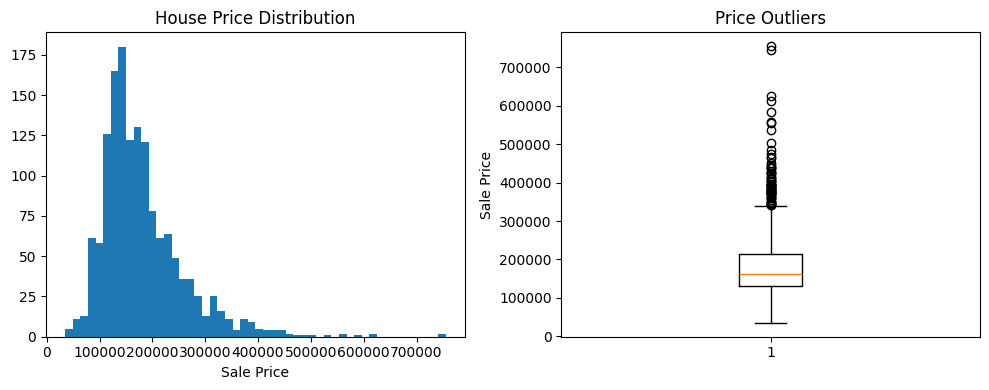

In [6]:
# What are we predicting?
print(train['SalePrice'].describe())

# Plot it
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(train['SalePrice'], bins=50)
plt.xlabel('Sale Price')
plt.title('House Price Distribution')

plt.subplot(1, 2, 2)
plt.boxplot(train['SalePrice'])
plt.ylabel('Sale Price')
plt.title('Price Outliers')

plt.tight_layout()
plt.show()

## Target Variable (SalePrice)
- Range: $34,900 to $755,000
- Median: ~$163,000
- Distribution is RIGHT-SKEWED (long tail on expensive side)
- Several outliers above $600k
- **Action item:** Might need to log-transform this for modeling

Columns with missing values:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


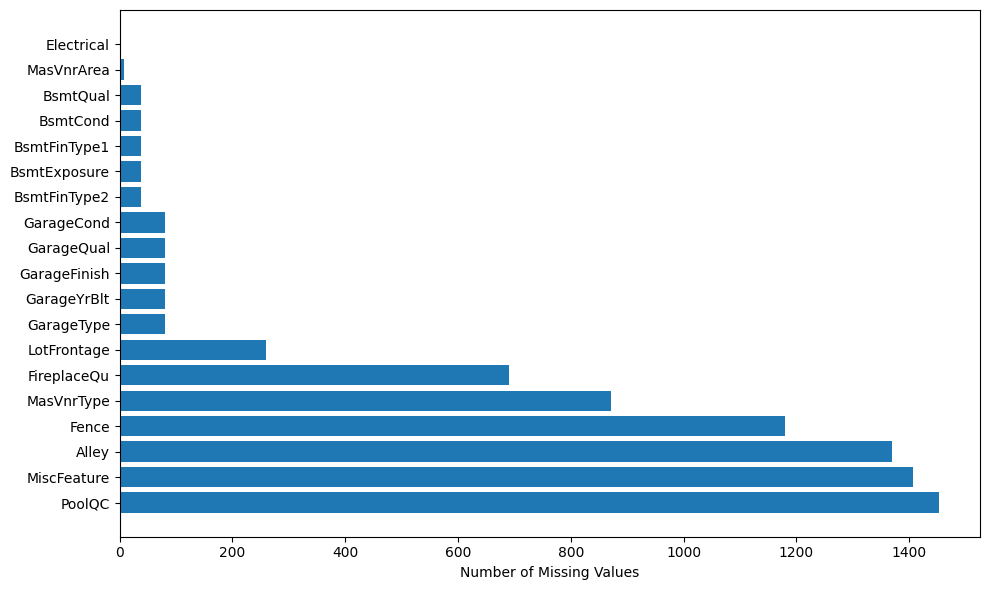

In [7]:
# Which columns have missing data?
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

print("Columns with missing values:")
print(missing)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(missing.index, missing.values)
plt.xlabel('Number of Missing Values')
plt.tight_layout()
plt.show()

## Missing Values
- PoolQC: 1453/1460 missing (99%!) - Most houses don't have pools
- MiscFeature: 1406/1460 missing - Similar reason
- Alley: 1369/1460 missing - Most houses don't have alley access
- Fence: 1179/1460 missing

**Strategy:**
- High missing (>80%): Maybe drop these columns
- Medium missing (20-80%): Impute or create "missing" category
- Low missing (<20%): Simple imputation (mean/median/mode)

Top 10 features correlated with price:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
dtype: float64


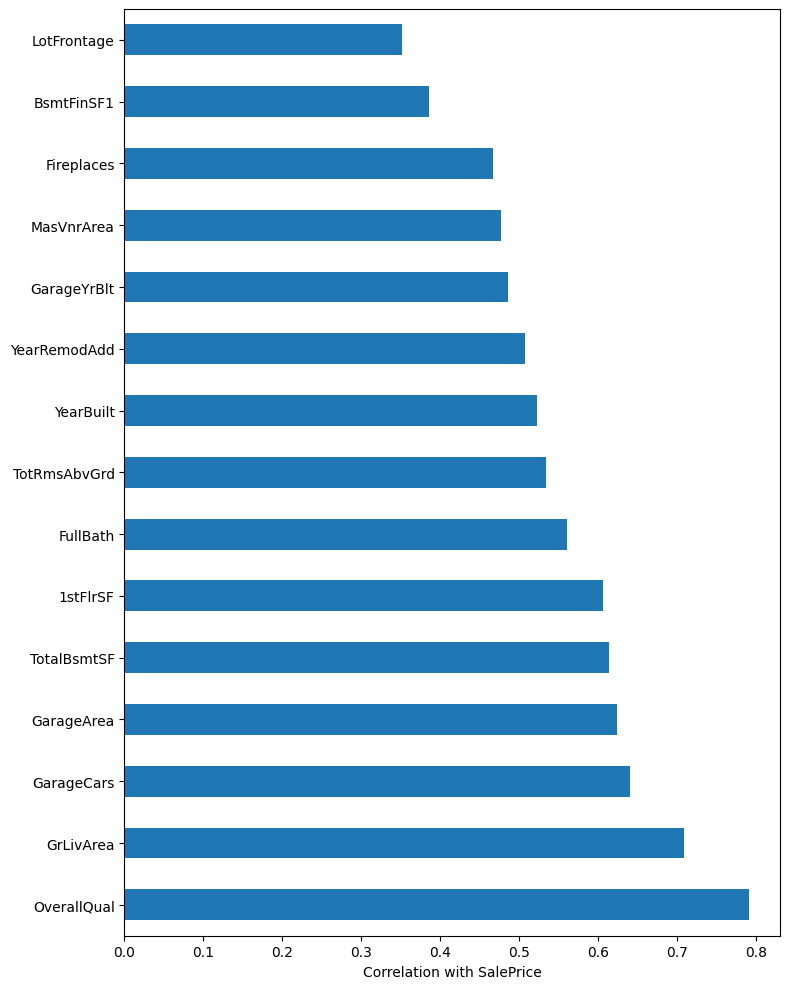

In [8]:
# Which features correlate with price?
numerical_features = train.select_dtypes(include=['int64', 'float64']).columns

correlations = train[numerical_features].corrwith(train['SalePrice']).sort_values(ascending=False)

print("Top 10 features correlated with price:")
print(correlations.head(11))  # 11 because SalePrice itself is first

# Plot
plt.figure(figsize=(8, 10))
correlations.drop('SalePrice').head(15).plot(kind='barh')
plt.xlabel('Correlation with SalePrice')
plt.tight_layout()
plt.show()

## Most Important Features (Initial)
1. OverallQual (0.79) - Quality rating strongly affects price ✅
2. GrLivArea (0.71) - Bigger living area = higher price ✅
3. GarageCars (0.64) - More garage space = higher price ✅
4. GarageArea (0.62) - Related to above
5. TotalBsmtSF (0.61) - Basement size matters

**Insight:** Quality and size are the main drivers of price